## Import Statements

In [25]:
import copy

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, 
                             accuracy_score, balanced_accuracy_score)
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [26]:
data = pd.read_json('../Data/data.json')

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(data[['label', 'algalBloomSheen_one_day', 'algalBloomSheen_three_day', 'algalBloomSheen_one_week']])

labels = data[['label']]
data = data.drop('label', axis='columns')

## Add Features

In [336]:
data['log_turbidity'] = np.log(data['turbidity'] + 1)

## Correlation

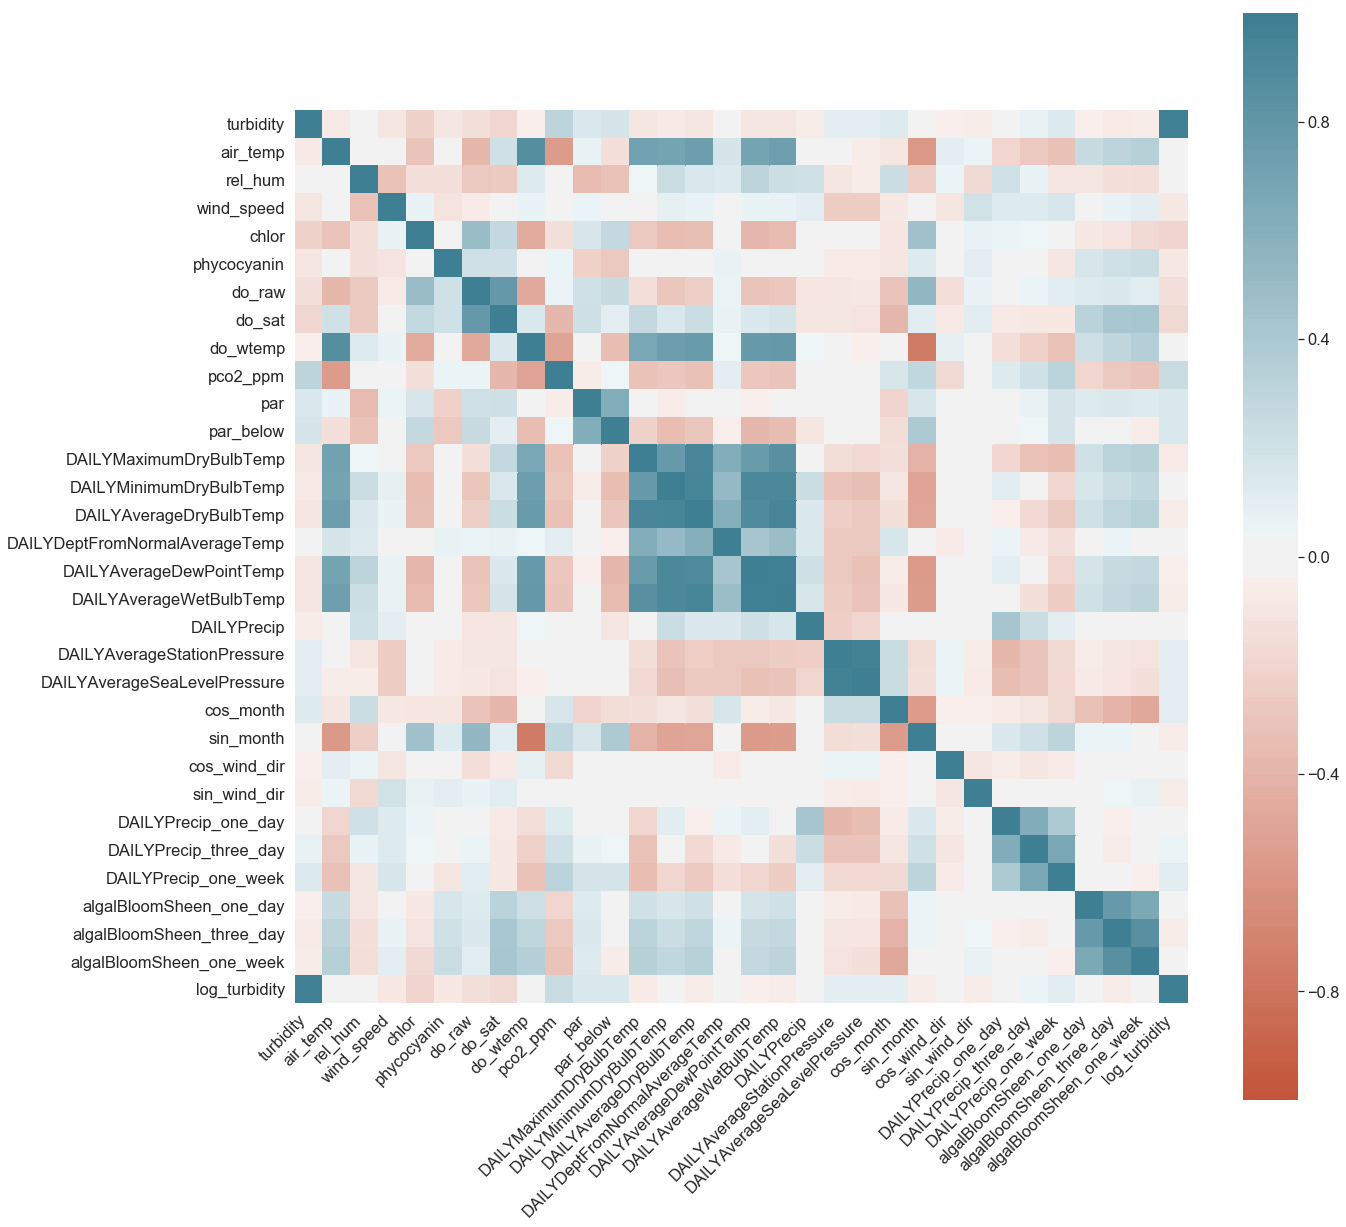

In [338]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Logistic Regression

In [299]:
corr_thresh = 0.80  # threshold for correlation. for any two variables with correlation > thresh, one is removed

thresh = corr.abs() > corr_thresh

keep = copy.deepcopy(data.columns).to_list()

print('Removed features: ')
# keep features whose correlation with other features is <= corr_thresh
for i in range(0, len(thresh.index)):
    for j in range(i+1, len(thresh.columns)):
        if thresh.iloc[i, j]:
            if thresh.columns[j] in keep:
                print('\t', thresh.columns[j])
                keep.remove(thresh.columns[j])


Removed features: 
	 do_wtemp
	 DAILYAverageDryBulbTemp
	 DAILYAverageWetBulbTemp
	 DAILYAverageDewPointTemp
	 DAILYAverageSeaLevelPressure
	 algalBloomSheen_one_week


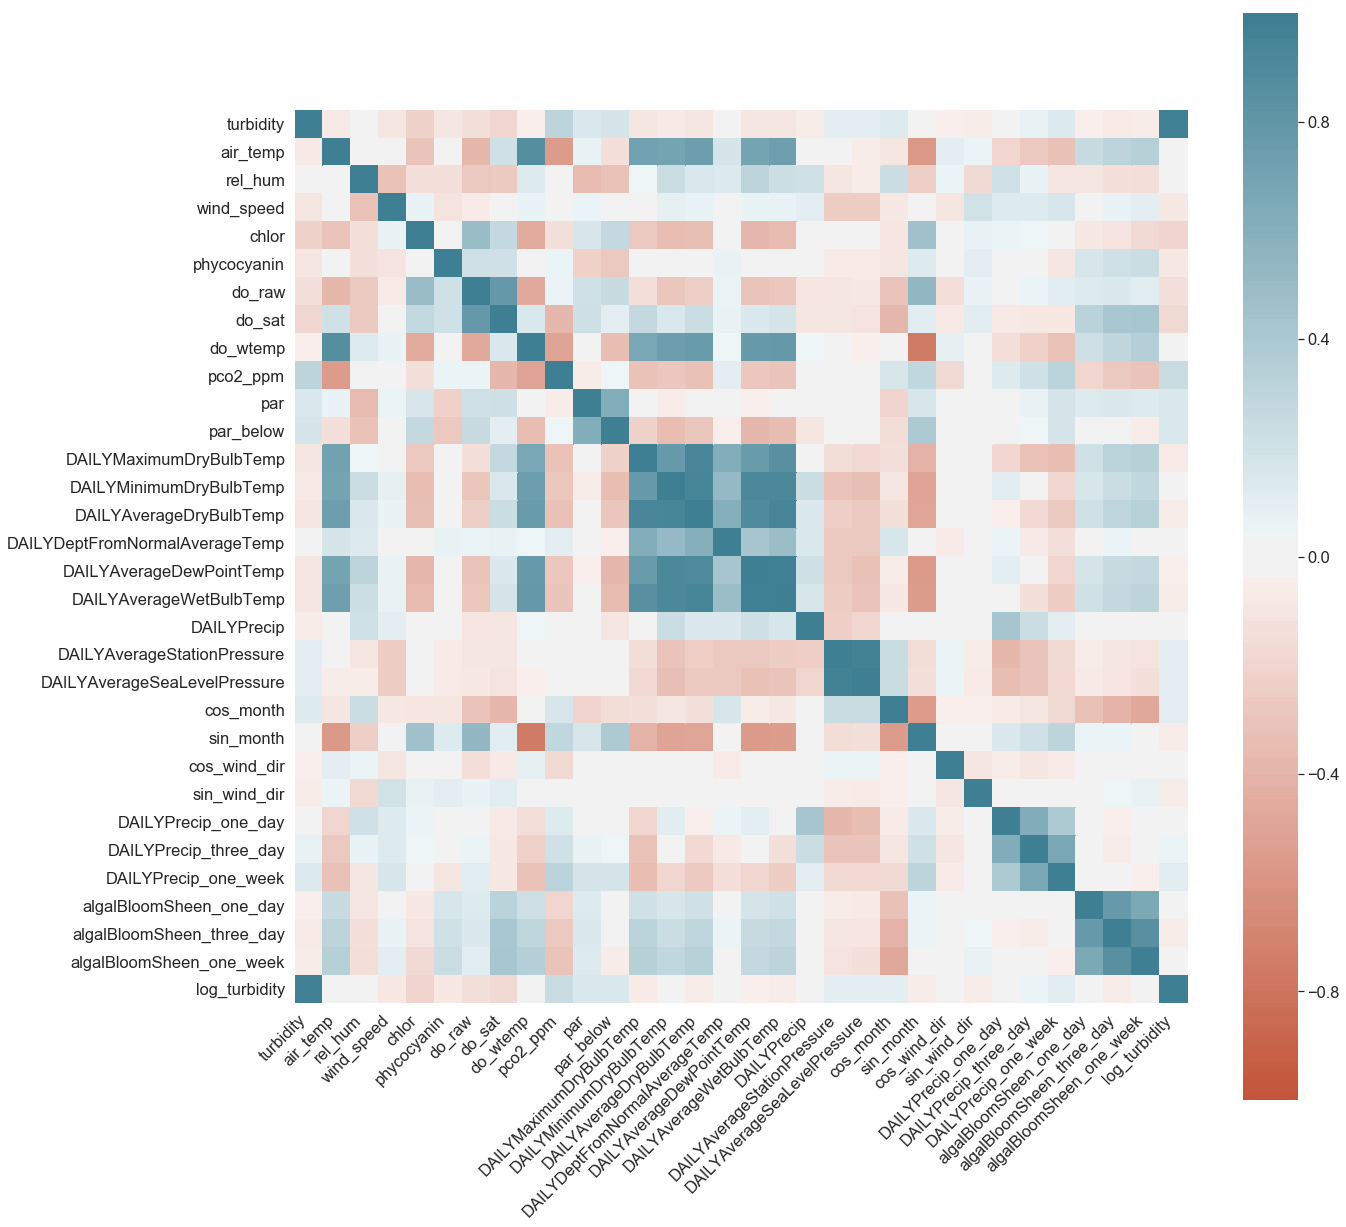

In [341]:
# handpicked keep based on results above
# keep = ['turbidity', 'rel_hum', 'wind_speed', 'chlor',
#        'phycocyanin', 'do_sat', 'do_wtemp', 'pco2_ppm', 'par',
#        'par_below', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
#        'DAILYPrecip',
#        'DAILYAverageStationPressure',
#        'cos_month', 'sin_month', 'cos_wind_dir', 'sin_wind_dir',
#        'DAILYPrecip_one_day', 'DAILYPrecip_three_day', 'DAILYPrecip_one_week',
#        'algalBloomSheen_one_week']

# new = data[keep]
new = data

new_corr = new.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    new_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [342]:
data.columns

Index(['turbidity', 'air_temp', 'rel_hum', 'wind_speed', 'chlor',
       'phycocyanin', 'do_raw', 'do_sat', 'do_wtemp', 'pco2_ppm', 'par',
       'par_below', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp',
       'DAILYAverageDryBulbTemp', 'DAILYDeptFromNormalAverageTemp',
       'DAILYAverageDewPointTemp', 'DAILYAverageWetBulbTemp', 'DAILYPrecip',
       'DAILYAverageStationPressure', 'DAILYAverageSeaLevelPressure',
       'cos_month', 'sin_month', 'cos_wind_dir', 'sin_wind_dir',
       'DAILYPrecip_one_day', 'DAILYPrecip_three_day', 'DAILYPrecip_one_week',
       'algalBloomSheen_one_day', 'algalBloomSheen_three_day',
       'algalBloomSheen_one_week', 'log_turbidity'],
      dtype='object')

In [384]:
X_train, X_test, y_train, y_test = train_test_split(
    new.values,
    labels.values.ravel(),
    train_size=0.7,
    test_size=0.3,
    shuffle=True,
    stratify=labels.values.ravel()
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [385]:
model = LogisticRegression(
    penalty='l1',
    C=1,
    class_weight='balanced'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)

# for use with logistic regression only
coef_sort_idx = np.argsort(-np.abs(model.coef_[0]), kind='mergesort')

print('Feature weighting for logistic regression\n')
for idx in coef_sort_idx:
    coef = model.coef_[0][idx]
    
    if coef < 0:
        print('\t%0.4f' % model.coef_[0][idx], new.columns[idx])
    else:
        print('\t %0.4f' % model.coef_[0][idx], new.columns[idx])

Accuracy: 0.7539
Balanced Accuracy: 0.7539
F1 Score: 0.6357

Confusion Matrix:


/Users/Alliot/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0,1
0,103,25
1,22,41


Feature weighting for logistic regression

	-1.8144 do_raw
	 1.7027 do_sat
	 0.6961 algalBloomSheen_one_week
	 0.6507 sin_month
	 0.4091 DAILYAverageStationPressure
	 0.3504 turbidity
	-0.2856 DAILYAverageSeaLevelPressure
	-0.2831 air_temp
	 0.2583 algalBloomSheen_one_day
	-0.2516 DAILYPrecip_three_day
	-0.1837 cos_month
	 0.1627 algalBloomSheen_three_day
	-0.1431 log_turbidity
	 0.1222 phycocyanin
	 0.1109 rel_hum
	-0.1033 DAILYMinimumDryBulbTemp
	 0.0981 par_below
	 0.0870 DAILYPrecip_one_week
	 0.0753 chlor
	-0.0705 DAILYPrecip
	 0.0634 DAILYDeptFromNormalAverageTemp
	-0.0326 DAILYAverageDewPointTemp
	-0.0264 wind_speed
	 0.0110 sin_wind_dir
	-0.0079 pco2_ppm
	 0.0000 do_wtemp
	 0.0000 par
	 0.0000 DAILYMaximumDryBulbTemp
	 0.0000 DAILYAverageDryBulbTemp
	 0.0000 DAILYAverageWetBulbTemp
	 0.0000 cos_wind_dir
	 0.0000 DAILYPrecip_one_day


In [386]:
# Training results

y_pred = model.predict(X_train)

acc = accuracy_score(y_train, y_pred)
balanced_acc = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)

Accuracy: 0.7910
Balanced Accuracy: 0.7910
F1 Score: 0.7224
